# Build a neural network for pricing European Basket options using the data generated

In [55]:
# libraries
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping

### Load the data:

In [56]:
df = pd.read_csv('Basket_pricing_data.csv')

In [57]:
df.head()

,Time_to_maturity,Volatility,Rate,Prices,Strikes,Basket_Price
0,0.653711,0.312417,0.027366,97.971978,115.487802,4.617228
1,0.553308,0.226359,0.035768,90.747605,142.051180,0.032997
2,0.422998,0.850931,0.055041,92.668292,82.093287,25.696106
3,0.721452,0.684244,0.021393,92.337340,98.394511,19.428791
4,0.488079,0.520385,0.075003,95.283133,82.584249,21.935407


### Split the data:

In [58]:
def split_data(data, label, test_size=0.3):
    """           
    Parameters
    ----------

    data : pd.Dataframe
          The simulated data.
    label : str
          Name of the label column.
    test_size : float
          The proportion of the dataset in the test split.
    
    """
    # split the data into features and labels
    X = data.drop([label], axis=1)
    y = data[label]

    # split the data to training and testing
    X_train, X_test, y_train, y_test =\
                 train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [59]:
# split the data
X_train, X_test, y_train, y_test = split_data(df, 'Basket_Price', 0.2)

In [60]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 5), (2000, 5), (8000,), (2000,))

### Build the model:

To build the model, we use the sequential API of keras. 

* It is composed of Dense layers.
* The output layer is a Dense layer with 1 neuron as we are predicting a numerical value (regression problem) and a 'relu' activation function since the Price option needs to be at least 0.
* For the loss function, we use Mean squared error (MSE). This finds the average squared difference between the predicted value and the true value.

In [62]:
def build_model():
    """
    compiles and returns a Keras model
    """
    model = Sequential()

    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return(model)

In [63]:
epochs = 100
vs = 0.2 # validation_split
bs = 1024 # batch_size

# fit the model
model = build_model()
history = model.fit(X_train, y_train, epochs=epochs, validation_split=vs, batch_size=bs)

Epoch 1/100
7/7 [==============================] - 1s 98ms/step - loss: 291.3308 - mse: 291.3308 - val_loss: 70.9232 - val_mse: 70.9232
Epoch 2/100
7/7 [==============================] - 0s 66ms/step - loss: 80.6519 - mse: 80.6519 - val_loss: 74.7245 - val_mse: 74.7245
Epoch 3/100
7/7 [==============================] - 0s 68ms/step - loss: 67.9819 - mse: 67.9819 - val_loss: 56.6076 - val_mse: 56.6076
Epoch 4/100
7/7 [==============================] - 0s 66ms/step - loss: 58.1316 - mse: 58.1316 - val_loss: 57.1525 - val_mse: 57.1525
Epoch 5/100
7/7 [==============================] - 0s 72ms/step - loss: 56.3319 - mse: 56.3319 - val_loss: 56.0398 - val_mse: 56.0398
Epoch 6/100
7/7 [==============================] - 0s 66ms/step - loss: 56.4770 - mse: 56.4770 - val_loss: 56.8842 - val_mse: 56.8842
Epoch 7/100
7/7 [==============================] - 0s 68ms/step - loss: 56.4721 - mse: 56.4721 - val_loss: 55.2670 - val_mse: 55.2670
Epoch 8/100
7/7 [==============================] - 0s 66ms/s

In [65]:
results = model.evaluate(X_test, y_test)
print("test loss, test mae:", results)

63/63 [==============================] - 0s 3ms/step - loss: 5.1921 - mse: 5.1921
test loss, test mae: [5.192119121551514, 5.192119121551514]


In [66]:
start = time.time()
pred = model.predict(X_test)
end = time.time()
print(f"Runtime of the model on test set is {end - start}")

Runtime of the model on test set is 0.3056495189666748


In [ ]:
# save the model
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))
 

INFO:tensorflow:Assets written to: ram://4e0b5679-025a-4b99-a23a-b1428f66cf28/assets


NN prices vs BS prices for n iterations:


Text(0.5, 1.0, 'Basket_prices')

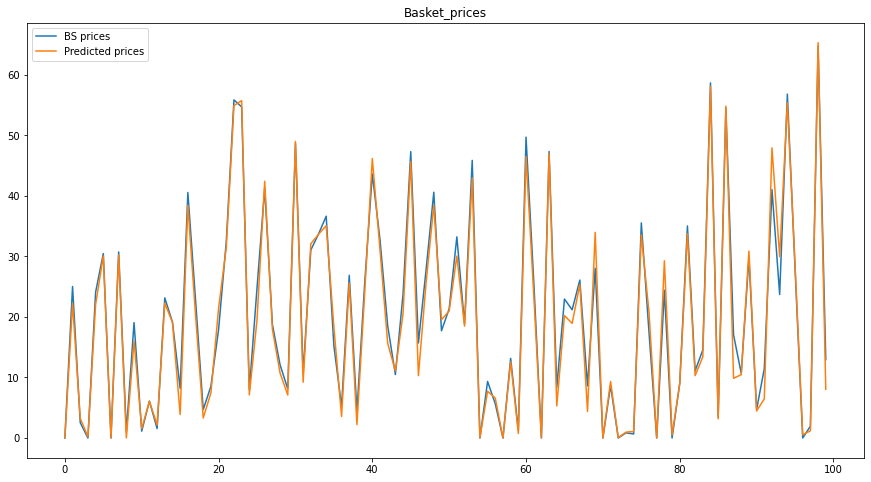

In [67]:
n = 100
plt.figure(figsize=(15,8))
plt.plot(range(n), pred.reshape((y_test.shape[0],))[:n], label='BS prices')
plt.plot(range(n),y_test[:n], label='NN prices')
plt.legend()
plt.title("Basket_prices")

# Compare NN prices Monte-Carlo simulations:

[Monte Carlo](https://www.goddardconsulting.ca/option-pricing-monte-carlo-index.html) Pricing formula:

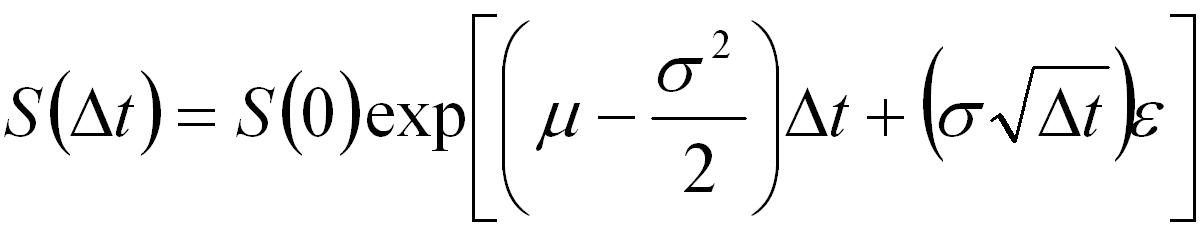

In [ ]:
def MC_pricing(S_0, K, r, T, sigma, M=1000):
    """           
    Parameters
    ----------
    S_0: stock price at time 0
    K: strike price
    r: risk-free rate
    T: maturity date
    sigma: volatility
    M: number of trails of MCS
    """
    B_Ts = np.random.normal(0, T, M)
    S_Ts = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * B_Ts)
    payoffs = np.maximum(S_Ts - K, np.zeros(M)) 
    return np.exp(-1 * r * T) * np.mean(payoffs)

In [ ]:
test = X_test.reset_index()
S_0 = test['Prices']
K = test['Strikes']
r = test['Rate']
T = test['Time_to_maturity']
sigma = test['Volatility']
  

In [ ]:
%time 
start = time.time()
mc_prices = []
for i in range(test.shape[0]):
    mc_price = MC_pricing(S_0[i], K[i], r[i], T[i], sigma[i], M=1000)
    mc_prices.append(mc_price)
end = time.time()
print(f"Runtime of MC is : .... {end - start}")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.06 µs
Runtime of MC is : .... 0.4110136032104492


MC prices vs BS prices for n iterations:

Text(0.5, 1.0, 'Basket_prices')

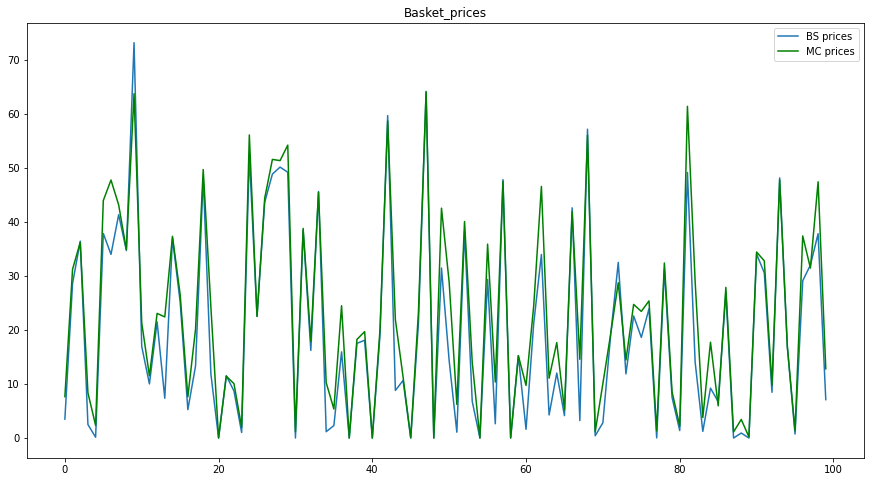

In [ ]:

n = 100
plt.figure(figsize=(15,8))
plt.plot(range(n), mc_prices[:n], label='BS prices')
plt.plot(range(n),y_test[:n], label='MC prices', 'g')
plt.legend()
plt.title("Basket_prices")

## Comparison:

Under Black-Scholes assumptions, Neural Network approach reduces the computing time of basket options pricing compared to Monte Carlo approach.